In [ ]:
# Unzipping the 'archive.zip' file
!unzip archive.zip

In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import random
#import cv2
import copy
import os
from sklearn.model_selection import train_test_split
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torchvision.transforms as transform
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from PIL import Image

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
# Specify the path to the dataset
path = 'chest_xray/chest_xray'

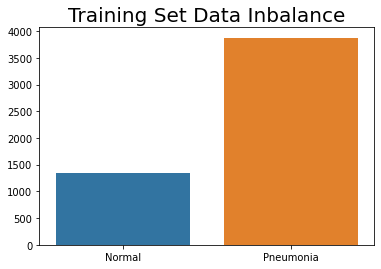

In [5]:
# Count the number of samples in the training set for each class
train_samplesize = pd.DataFrame.from_dict(
    {'Normal': [len([os.path.join(path+'/train/NORMAL', filename) 
                     for filename in os.listdir(path+'/train/NORMAL')])], 
     'Pneumonia': [len([os.path.join(path+'/train/PNEUMONIA', filename) 
                        for filename in os.listdir(path+'/train/PNEUMONIA')])]})

# Visualize the data imbalance in the training set using a bar plot
sns.barplot(data=train_samplesize).set_title('Training Set Data Inbalance', fontsize=20)
plt.show()

In [6]:
# Define the transformations for each dataset
transformer = {
    'dataset1': transform.Compose([transform.Resize(255),
                                            transform.CenterCrop(224),
                                            transform.RandomHorizontalFlip(),
                                            transform.RandomRotation(10),
                                            transform.RandomGrayscale(),
                                            transform.RandomAffine(translate=(0.05,0.05), degrees=0),
                                            transform.ToTensor()
                                           ]),
    
    'dataset2' : transform.Compose([transform.Resize(255),
                                            transform.CenterCrop(224),
                                            transform.RandomHorizontalFlip(p=1),
                                            transform.RandomGrayscale(),
                                            transform.RandomAffine(translate=(0.1,0.05), degrees=10),
                                            transform.ToTensor()
                                    
                                           ]),
    'dataset3' : transform.Compose([transform.Resize(255),
                                            transform.CenterCrop(224),
                                            transform.RandomHorizontalFlip(p=0.5),
                                            transform.RandomRotation(15),
                                            transform.RandomGrayscale(p=1),
                                            transform.RandomAffine(translate=(0.08,0.1), degrees=15),
                                            transform.ToTensor()
                                           ]),
}


In [7]:
# Create the ImageFolder datasets using the defined transformations
dataset1 = ImageFolder(path+'/train', 
                      transform=transformer['dataset1'])

dataset2 = ImageFolder(path+'/train', 
                      transform=transformer['dataset2'])

dataset3 = ImageFolder(path+'/train', 
                      transform=transformer['dataset3'])


# Split the datasets for balancing
norm1, _ = train_test_split(dataset2, test_size= 3875/(1341+3875), shuffle=False)
norm2, _ = train_test_split(dataset3, test_size= 4023/(1341+3875), shuffle=False)

# Concatenate the datasets
dataset = ConcatDataset([dataset1, norm1, norm2])

# Calculate the length of the concatenated dataset
len(dataset)

7750

In [8]:
random_seed = 2020
train_ds, val_ds = train_test_split(dataset, test_size=0.3, random_state=random_seed)
len(train_ds), len(val_ds)

(5425, 2325)

In [9]:
X_train = []
y_train = []

for i in range(len(train_ds)):
    X_train.append(train_ds[i][0])
    y_train.append(train_ds[i][1])

In [10]:
batch_size=50

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
loaders = {'train':train_dl, 'val':val_dl}
dataset_sizes = {'train':len(train_ds), 'val':len(val_ds)}

In [11]:
testset = ImageFolder(path+'/test', 
                           transform=transform.Compose([transform.Resize(255),
                                                 transform.CenterCrop(224),                                                              
                                                 transform.ToTensor(),
                                                ]))

In [12]:
test_ds, test1_ds = train_test_split(testset, test_size=0.001, random_state=random_seed)

In [13]:
X_test = []
y_test = []

for i in range(len(test_ds)):
    X_test.append(test_ds[i][0])
    y_test.append(test_ds[i][1])

In [14]:
test_dl = DataLoader(testset, batch_size=256)


In [15]:
print(dataset1.classes)

['NORMAL', 'PNEUMONIA']


In [16]:
# Function for plotting samples
def plot_samples(samples):  
    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(30,8))
    for i in range(len(samples)):
        image = cv2.cvtColor(imread(samples[i]), cv2.COLOR_BGR2RGB)
        ax[i//5][i%5].imshow(image)
        if i<5:
            ax[i//5][i%5].set_title("Normal", fontsize=20)
        else:
            ax[i//5][i%5].set_title("Pneumonia", fontsize=20)
        ax[i//5][i%5].axis('off')

In [17]:
X_train = torch.stack(X_train)
y_train = torch.tensor(y_train)

X_train = np.asarray(X_train)

y_train = np.asarray(y_train)

print(X_train.shape, y_train.shape)

X_train = X_train.reshape((5425,224,224,3))
y_train = y_train.reshape((5425,1))
print(X_train.shape, y_train.shape)

(5425, 3, 224, 224) (5425,)
(5425, 224, 224, 3) (5425, 1)


In [18]:
X_test = torch.stack(X_test)
y_test = torch.tensor(y_test)

X_test = np.asarray(X_test)

y_test = np.asarray(y_test)

print(X_test.shape, y_test.shape)

X_test = X_test.reshape((623,224,224,3))
y_test = y_test.reshape((623,1))
print(X_test.shape, y_test.shape)

(623, 3, 224, 224) (623,)
(623, 224, 224, 3) (623, 1)


In [19]:


y_train = np.eye(2)[y_train]
y_test = np.eye(2)[y_test]


In [ ]:
np.save('X_train.npy', X_train)
np.save('X_test.npy', X_test)
np.save('y_train.npy', y_train)
np.save('y_test.npy', y_test)